In [1]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from trainRNNbrain.datasaver.DataSaver import DataSaver
from trainRNNbrain.analyzers.DynamicSystemAnalyzer import *
from trainRNNbrain.analyzers.PerformanceAnalyzer import *
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
from trainRNNbrain.rnns.RNN_torch import RNN_torch
from trainRNNbrain.utils import get_project_root, numpify, orthonormalize
from trainRNNbrain.trainer.Trainer import Trainer
from trainRNNbrain.tasks.TaskCDDM import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA

python: can't open file '/Users/tolmach/Documents/GitHub/trainRNNbrain/jupyter/../../style/style_setup.py': [Errno 2] No such file or directory


In [4]:
import typing as T
import os
import matplotlib.colors as mcolors
import matplotlib.font_manager as mfonts
from trainRNNbrain.utils import get_project_root
from matplotlib import pyplot as plt

def setup_fonts(fontpaths, verbose: bool = False, **kwargs):
    for font in sorted(mfonts.findSystemFonts(fontpaths=fontpaths, **kwargs)):
        mfonts.fontManager.addfont(font)
        if verbose: print(f'font:\t{os.path.basename(font)}')


def setup_colors(themepaths, verbose: bool = False):
    for themepath in themepaths:
        with open(themepath, 'rt') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line.startswith('#'): continue
                names, value = line.split(':')
                value = value.strip()
                for name in names.split(','):
                    name = name.strip()
                    mcolors._colors_full_map[name] = value  # type: ignore
                    if verbose: print(f'color:\t{name:16s} {value:}')

setup_fonts([os.path.join(get_project_root(), "style", "assets", "fonts")], verbose=False)
setup_colors([os.path.join(get_project_root(), "style", "assets", "styles", "scientific.txt")], verbose=False)
plt.style.use([os.path.join(get_project_root(), 'style', 'assets', 'styles', 'scientific.mplstyle'), {'figure.dpi': 144}])

In [5]:
# defining RNN:
N = 50
activation_name = 'relu'
activation_slope = 1.0
exc_to_inh_ratio = 4.0 # there 4 times more excitatory neurons
dt = 1
tau = 10
constrained = True # whether to impose Dale constraint and positivity of inputs and outputs
connectivity_density_rec = 1.0 # no sparsity here
spectral_rad = 1.2 
sigma_inp = 0.05
sigma_rec = 0.05
seed = 0
input_size = 6
output_size = 2

In [6]:
# Task:
T = 60
n_steps = int(np.ceil(T/dt))
cue_on = 0
cue_off = n_steps
stim_on = n_steps//3
stim_off = n_steps
dec_on = 2 * n_steps//3
dec_off = n_steps
abs_coherences = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 1])
coherences = np.concatenate([-1.0 * abs_coherences[::-1], np.array([0]), abs_coherences])

In [7]:
# Trainer:
lambda_orth = 0.3
lambda_r = 0.5
train_mask = np.concatenate([np.arange(n_steps//3), 2 * (n_steps//3) + np.arange(n_steps//3)])
max_iter = 1000
tol = 1e-10
lr = 0.02
weight_decay = 1e-6
same_batch = True # generate new bath every new iteration

In [8]:
# creating instances:
#RNN
rnn_torch = RNN_torch(N=N,
                      activation_name=activation_name,
                      activation_slope=activation_slope,
                      exc_to_inh_ratio=exc_to_inh_ratio,
                      dt=dt,
                      tau=tau,
                      input_size=input_size,
                      output_size=output_size,
                      constrained=constrained,
                      sigma_inp=sigma_inp,
                      sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      seed=seed)

#task
task = TaskCDDM(n_steps=n_steps,
                n_inputs=input_size,
                n_outputs=output_size, 
                cue_on=cue_on, cue_off=cue_off,
                stim_on=stim_on, stim_off=stim_off,
                dec_on=dec_on, dec_off=dec_off,
               coherences=coherences)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
#trainer
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


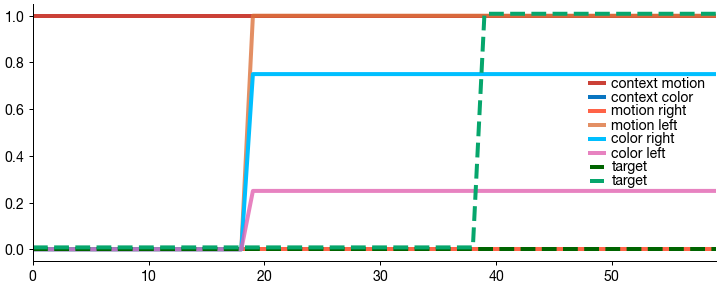

In [9]:
#plotting individual trials
ind = 11

inputs, targets, conditions = task.get_batch()
fig = plt.figure(figsize = (5, 2))
plt.plot(inputs[0, :, ind] + 0.01 * np.random.randn(), color = 'red', linewidth=2, label = 'context motion')
plt.plot(inputs[1, :, ind] + 0.01 * np.random.randn(), color = 'blue', linewidth=2,label = 'context color')
plt.plot(inputs[2, :, ind], color = 'tomato', linewidth=2, label = 'motion right')
plt.plot(inputs[3, :, ind], color = 'orange', linewidth=2, alpha = 0.8, label = 'motion left')
plt.plot(inputs[4, :, ind], color = 'deepskyblue', linewidth=2, label = 'color right')
plt.plot(inputs[5, :, ind], color = 'magenta', linewidth=2, alpha = 0.8, label = 'color left')
plt.plot(targets[0, :, ind] + 0.01 * np.random.randn(), color = 'darkgreen', linewidth=2, linestyle = '--', label = 'target')
plt.plot(targets[1, :, ind] + 0.01 * np.random.randn(), color = 'green', linewidth=2, linestyle = '--', label = 'target')
plt.legend(loc = 0)
plt.ylim([-0.05, 1.05])
plt.show()

iteration 0, train loss: 1.928688, validation loss: 1.839331
iteration 1, train loss: 1.835427, validation loss: 1.823878
iteration 2, train loss: 1.826859, validation loss: 1.792336
iteration 3, train loss: 1.79475, validation loss: 1.740066
iteration 4, train loss: 1.742762, validation loss: 1.66331
iteration 5, train loss: 1.664797, validation loss: 1.563133
iteration 6, train loss: 1.564456, validation loss: 1.45336
iteration 7, train loss: 1.455582, validation loss: 1.353162
iteration 8, train loss: 1.354435, validation loss: 1.264596
iteration 9, train loss: 1.266575, validation loss: 1.181315
iteration 10, train loss: 1.18365, validation loss: 1.105798
iteration 11, train loss: 1.107623, validation loss: 1.032785
iteration 12, train loss: 1.033992, validation loss: 0.962212
iteration 13, train loss: 0.96348, validation loss: 0.894864
iteration 14, train loss: 0.896049, validation loss: 0.831274
iteration 15, train loss: 0.831906, validation loss: 0.771664
iteration 16, train los

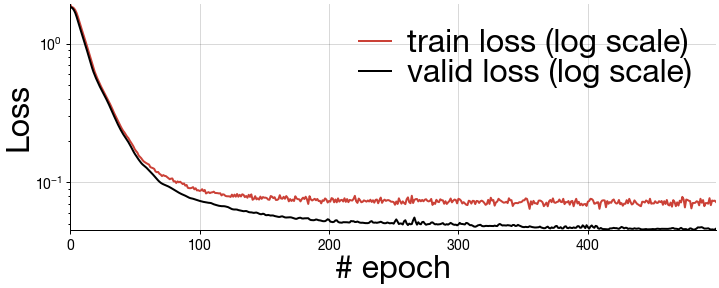

In [9]:
# # training RNNs
# trained_rnn, train_losses, val_losses, best_rnn_params = trainer.run_training(train_mask=train_mask, same_batch=same_batch, shuffle=False)

# #save the parameters
# # pickle.dump(best_rnn_params, open("./training_CDDM_example/best_rnn_params_CDDM.pkl", "wb+"))

# fig_trainloss = plt.figure(figsize=(5, 2))
# plt.plot(train_losses, linewidth=2, color='r', label='train loss (log scale)')
# plt.plot(val_losses, linewidth=2, color='b', label='valid loss (log scale)')
# plt.yscale("log")
# plt.grid(True)
# plt.xlabel("# epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [10]:
best_rnn_params = pickle.load(open("./training_CDDM_example/best_rnn_params_CDDM.pkl", "rb+"))
best_rnn_params.keys()

dict_keys(['activation_name', 'activation_slope', 'W_out', 'W_inp', 'W_rec', 'y_init', 'N', 'dt', 'tau'])

In [11]:
# validate
RNN_valid = RNN_numpy(N=best_rnn_params["N"],
                      dt=best_rnn_params["dt"],
                      tau=best_rnn_params["tau"],
                      W_inp=best_rnn_params["W_inp"],
                      W_rec=best_rnn_params["W_rec"],
                      W_out=best_rnn_params["W_out"],
                      activation_name=activation_name,
                      activation_slope=activation_slope)

In [12]:
analyzer = PerformanceAnalyzerCDDM(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      train_mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)
print(f"MSE validation: {np.round(score, 5)}")

MSE validation: 0.07049


Plotting random trials


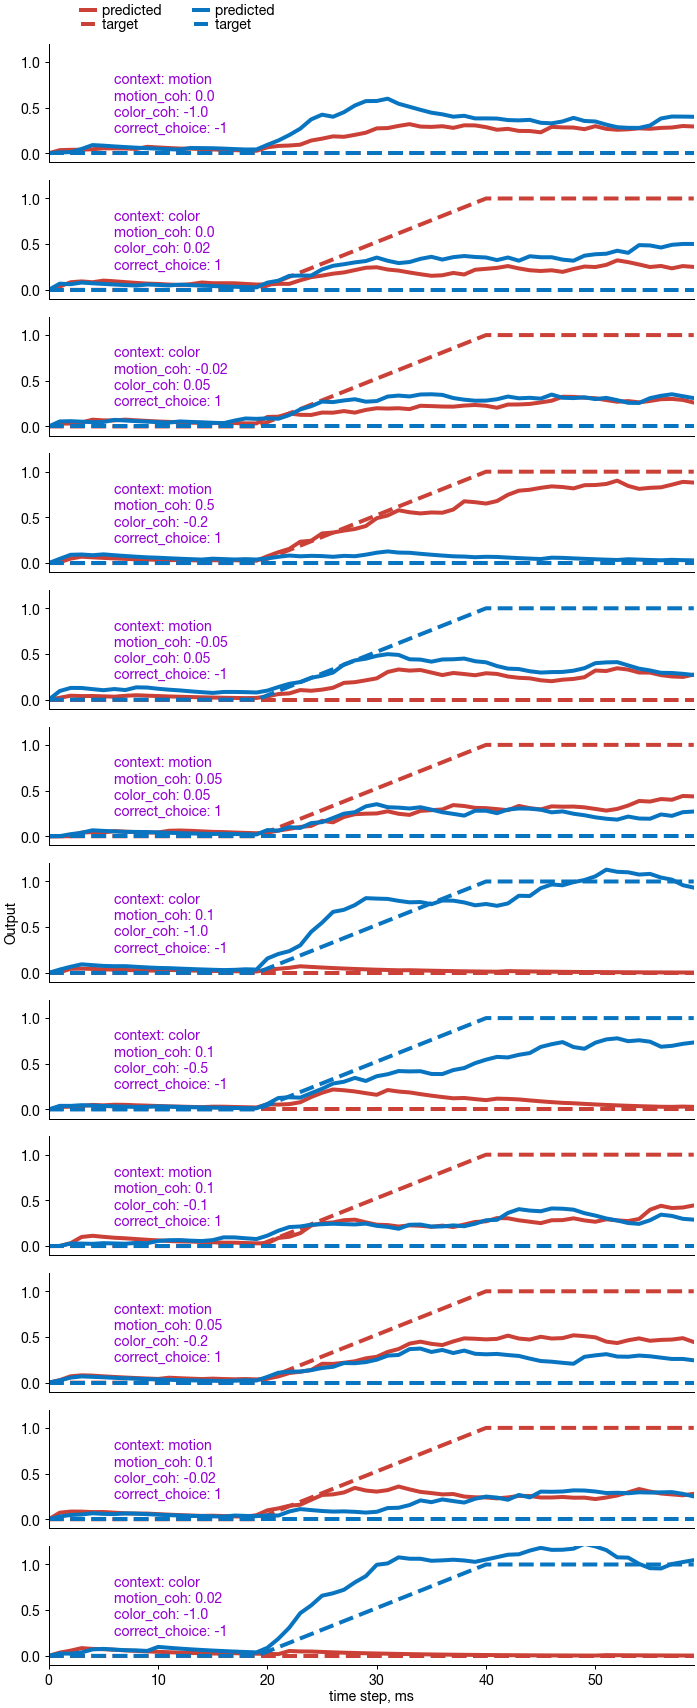

In [13]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
conditions = [conditions_valid[ind] for ind in inds]

analyzer.plot_trials(input_batch=inputs, target_batch=targets, mask=train_mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp, conditions=conditions)
plt.show()


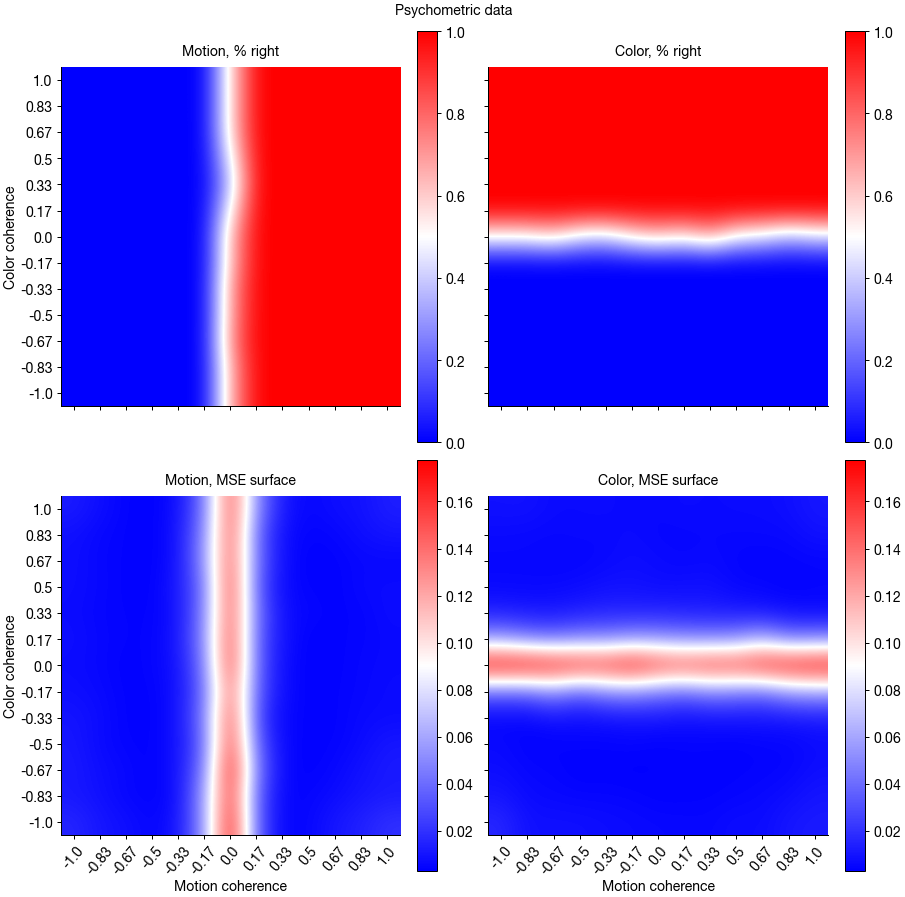

In [14]:
num_levels = len(coherences)
analyzer.calc_psychometric_data(task, train_mask, num_levels=num_levels, num_repeats=31, sigma_rec=0.03, sigma_inp=0.03)
fig_psycho = analyzer.plot_psychometric_data(show_axeslabels=True, show_MSE_surface=True, show_colorbar = True)
plt.show()

In [15]:
RNN_valid.reset_state()
RNN_valid.clear_history()

In [19]:
dsa = DynamicSystemAnalyzerCDDM(RNN_valid, task)

params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}

dsa.get_fixed_points(Input=np.array([1, 0, 0.5, 0.5, 0.5, 0.5]), **params)
dsa.get_fixed_points(Input=np.array([0, 1, 0.5, 0.5, 0.5, 0.5]), **params)

pickle.dump(dsa.fp_data, open("./training_CDDM_example/fp_data.pkl", "wb+"))


In [16]:

choice_axis = RNN_valid.W_out.flatten() if RNN_valid.W_out.shape[0] == 1 else (RNN_valid.W_out[0, :] - RNN_valid.W_out[1, :])
context_axis = RNN_valid.W_inp[:, 0] - RNN_valid.W_inp[:, 1]
sensory_axis = np.sum([RNN_valid.W_inp[:, i] for i in [2, 3, 4, 5]])

P_matrix = np.zeros((RNN_valid.N, 3))
P_matrix[:, 0] = choice_axis
P_matrix[:, 1] = context_axis
P_matrix[:, 2] = sensory_axis

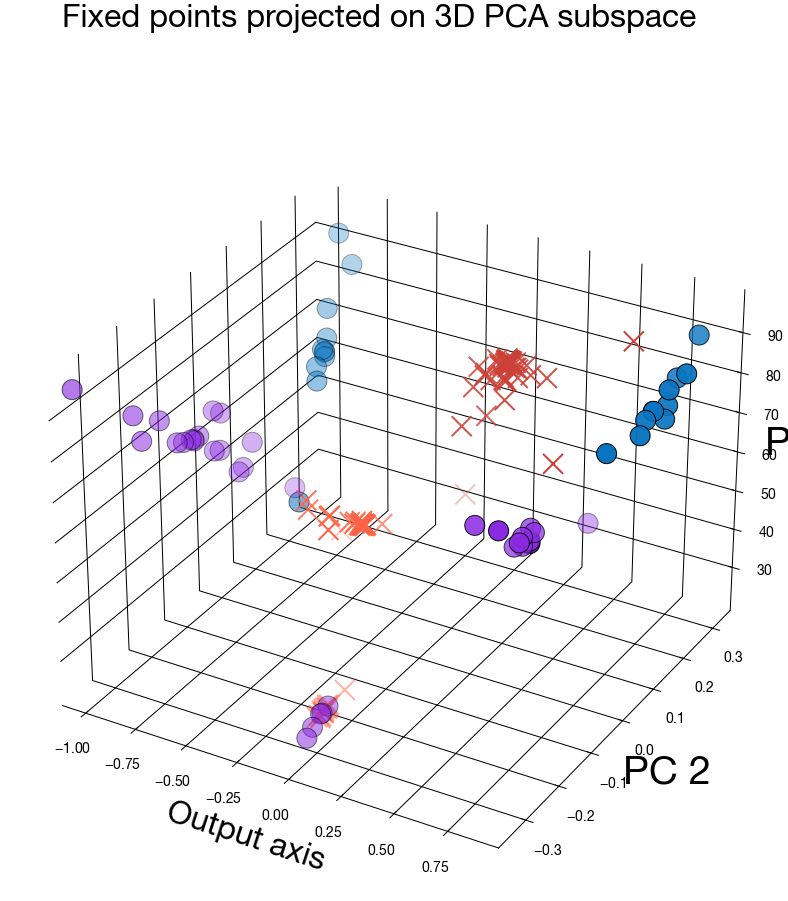

In [19]:
# %matplotlib widget
fp_data = pickle.load(open("./training_CDDM_example/fp_data.pkl", "rb+"))
dsa = DynamicSystemAnalyzerCDDM(RNN_valid, task)
dsa.fp_data = fp_data
fig_fp = dsa.plot_fixed_points(projection='3D', P=P_matrix)
plt.xlabel("Output axis", fontsize=16)
plt.show()

In [21]:
dsa.calc_LineAttractor_analytics()

Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

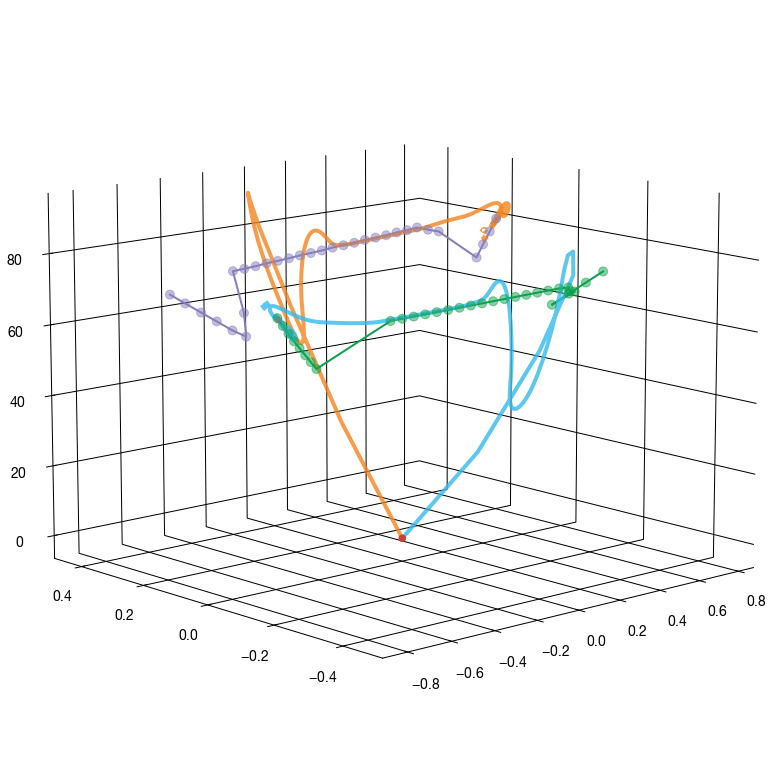

In [22]:
# %matplotlib widget
fig_LA = dsa.plot_LineAttractor_3D()
plt.show()